# Dogs vs. cats image classification: Inception V3

## 1. Notebook set-up

### 1.1. Imports & environment

In [1]:
# Standard library imports
import os
import sys
import glob
import pickle
from pathlib import Path
from random import randrange

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Use a specific GPU, if desired
os.environ['CUDA_VISIBLE_DEVICES']='2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import inception_v3
from keras.models import Model
from keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

# Import SDG optimizer correctly based on the TensorFlow version
tf_version=float('.'.join(tf.__version__.split('.')[0:2]))

if tf_version > 2.8:
    from keras.optimizers import SGD
    sgd=SGD(learning_rate=0.00005, momentum=0.9)

else:
    from keras.optimizers import gradient_descent_v2
    sgd=gradient_descent_v2.SGD(learning_rate=0.00005, momentum=0.9)

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import plot_single_training_run

### 1.2. Model save directory

In [2]:
# Decide what fine-tuning steps to run
tune_output=False
tune_inception_block=False

# Figure out if we are running on Kaggle or not, then set-up model save directory
# accordingly
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')
    model_path='/kaggle/working/models'

else:
    model_path='../data/models'

Path(model_path).mkdir(parents=True, exist_ok=True)
output_tuned_savefile=f'{model_path}/inceptionV3_output_tuned.pkl'
inception_tuned_savefile=f'{model_path}/inceptionV3_tuned.pkl'

## 2. Data preparation

### 2.1. Load the data paths

In [3]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path=prep_data()

# Get lists of training and validation dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

print()
print(training_data_path)
print(validation_data_path)
print(testing_data_path)


Not running in Kaggle notebook
Checking data prep
Data prep already complete

../data/images/training
../data/images/validation
../data/images/testing


### 2.2. Create training and validation datasets

In [4]:
image_size=[128,128]
input_shape=image_size + [3]

training_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=image_size,
    batch_size=256
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_data_path,
    image_size=image_size,
    batch_size=256
)

## 3. Model fine-tuning
### 3.1. Train output layers

In [5]:
%%time

if tune_output == True:

    # Define a preprocessing model
    preprocessing_input=layers.Input(shape=input_shape)
    x=layers.RandomFlip('horizontal')(preprocessing_input)
    x=layers.RandomRotation(0.1)(x)
    x=layers.RandomZoom(0.1)(x)
    preprocessing_output=inception_v3.preprocess_input(x)
    preprocessing_model=Model(inputs=preprocessing_input, outputs=preprocessing_output)

    # Create the base pre-trained model
    base_model=inception_v3.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

    # Train only the output layers by freezing all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add some output layers
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dropout(0.2)(x)
    x=layers.Dense(128,activation='relu')(x)
    predictions=layers.Dense(1, activation='sigmoid')(x)

    # Define the inception v3 model with the added output layers
    inception_model=Model(inputs=base_model.input, outputs=predictions)

    # Define the combined model
    model_input=layers.Input(shape=input_shape)
    preprocessing_output=preprocessing_model(model_input)
    inception_output=inception_model(preprocessing_output)
    model=Model(inputs=model_input, outputs=inception_output)

    # Compile the model to train on binary cross-entropy loss
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Train the model on the new data for a few epochs
    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=50
    )

    # Save the results
    with open(output_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(output_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()


CPU times: user 19.2 s, sys: 507 ms, total: 19.7 s
Wall time: 19.7 s


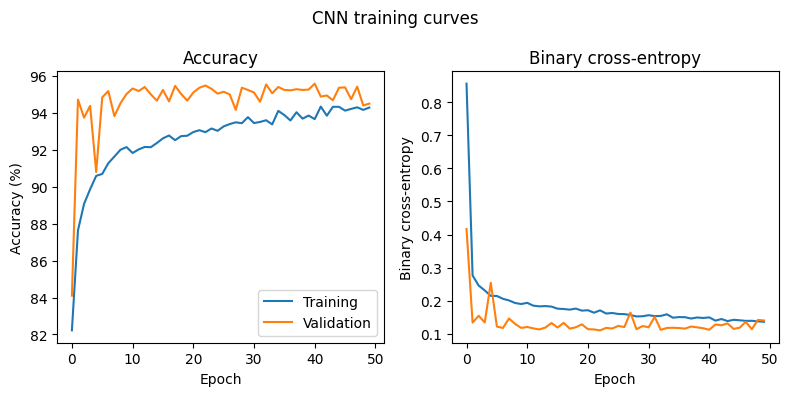

In [6]:
# Plot the results
plot_single_training_run(training_result).show()

### 3.2. Train inception layers

In [7]:
%%time

if tune_inception_block is True:

    # Train the top 2 inception blocks, by freezing the first 249 layers
    # of the inception model layer in the combined model
    for layer in model.layers[2].layers[:249]:
        layer.trainable=False
    for layer in model.layers[2].layers[249:]:
        layer.trainable=True

    # Recompile the model using SGD with a low learning rate
    model.compile(
        optimizer=sgd,
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    # Train again
    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=400
    )

    # Save the results
    with open(inception_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(inception_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()


CPU times: user 19.7 s, sys: 533 ms, total: 20.2 s
Wall time: 20.2 s


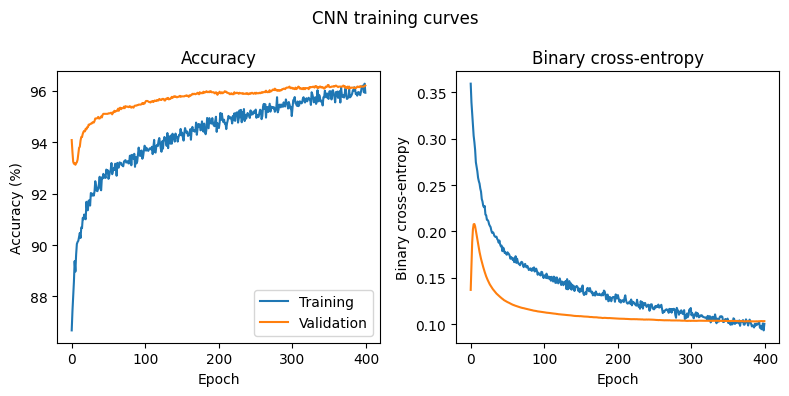

In [8]:
# Plot the results
plot_single_training_run(training_result).show()

## 4. Model evaluation

### 4.1. Testing dataset

In [9]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=image_size,
    batch_size=256,
    shuffle=False
)

metrics=training_result.model.evaluate(testing_dataset, verbose=0)
accuracy=metrics[1]*100
print(f'Test set accuracy: {accuracy:.1f}%')

Test set accuracy: 96.4%


### 4.2. Make testing predictions

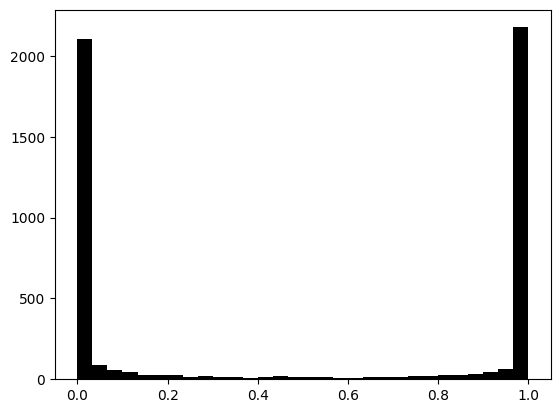

In [10]:
logits=training_result.model.predict(testing_dataset).flatten()

plt.hist(logits, color='black', bins=30)
plt.show()

### 4.3. Model performance

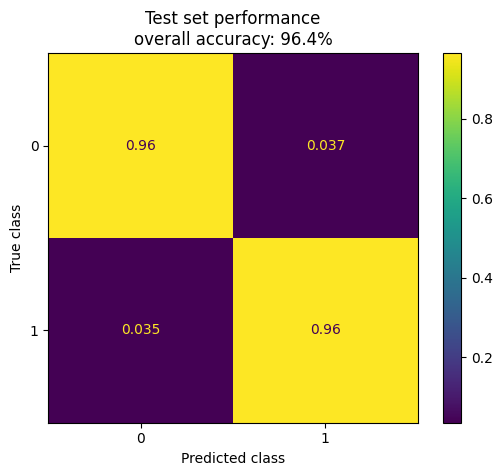

In [11]:
threshold=0.5
predictions=np.array([1 if p > threshold else 0 for p in logits])
labels=np.concatenate([y for x, y in testing_dataset], axis=0)

# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

### 4.4. Sample predictions

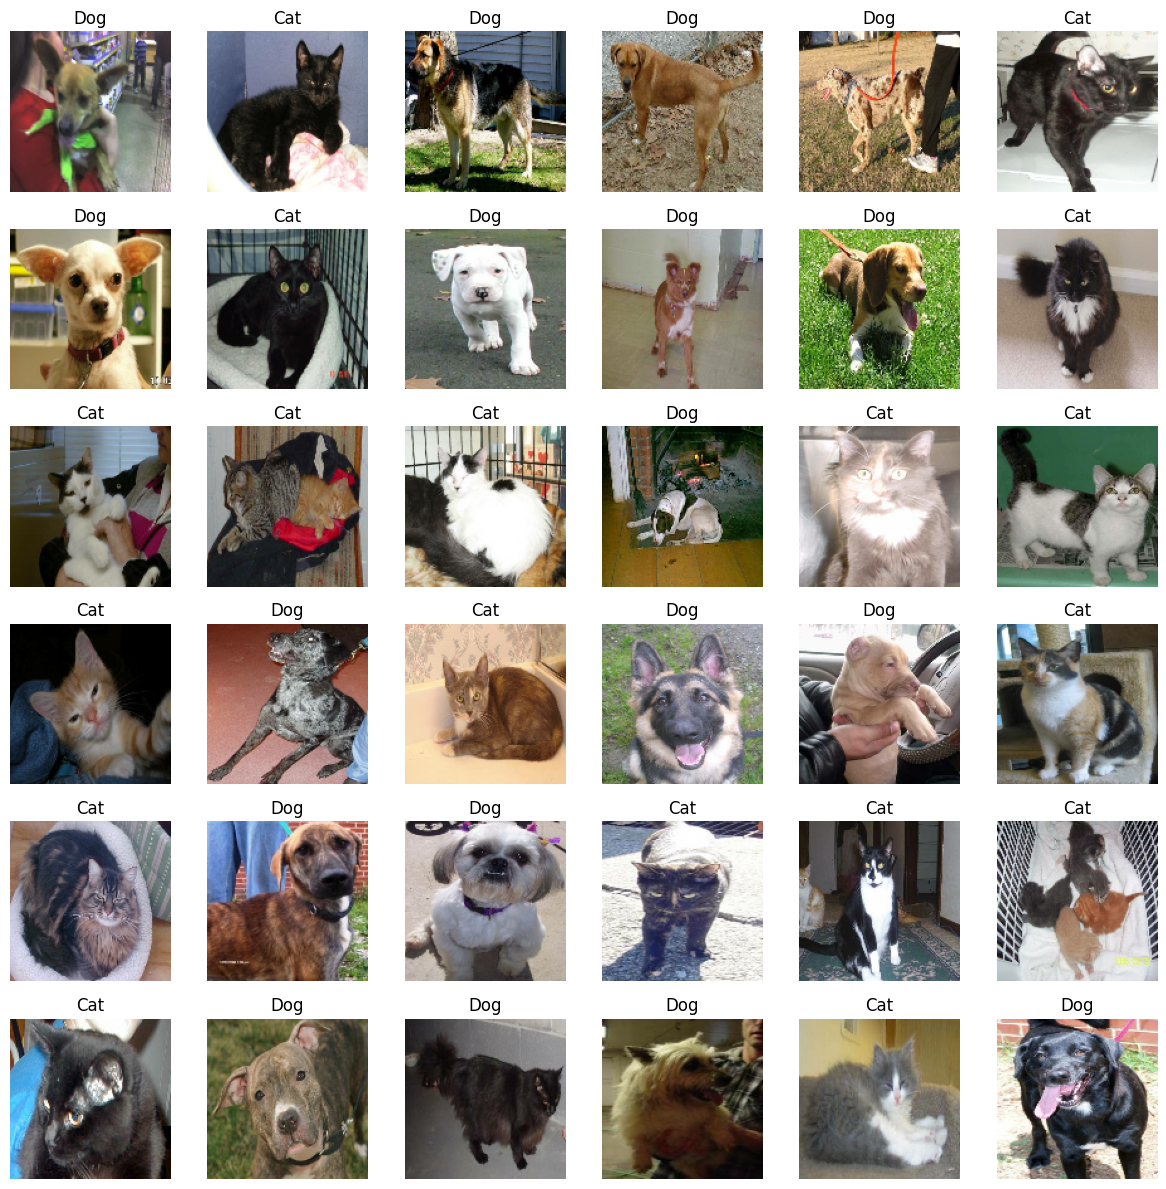

In [12]:
# Plot some random cat and dog images with labels
images=np.concatenate([x for x, y in testing_dataset], axis=0)

fig, axs=plt.subplots(6,6,figsize=(12, 12))
axs=axs.flatten()

for ax in axs:

    index=randrange(len(images))
    ax.imshow(images[index]/255)

    if predictions[index] == 0:
        ax.set_title('Cat')
    else:
        ax.set_title('Dog')

    ax.axis('off')

fig.tight_layout()